In [58]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy.constants as constants

class Shock:
    def __init__(self, config=None):
        self.config = config

        self.rider_mass = config["rider_weight"]


        self.spring_type = config["spring_type"]
        self.spring_constant = config["spring_constant"]
        self.initial_pressure = config["initial_pressure"] * 6894.76 # Convert psi to Pa
        self.progression_tokens = config["progression_tokens"] * 8 * 1e-6 # Each volume token is 8cm^3 then convert to m^3
        self.stanchion_radius = config["stanchion_diameter"] / 2 * 1e-3 # Convert mm to m
        self.travel_length = config["travel_length"] * 1e-3 # Convert mm to m
        self.temperature = constants.convert_temperature(config["temperature"], 'Fahrenheit', 'Kelvin')
        self.initial_volume = np.pi * (self.stanchion_radius)**2 * self.travel_length - self.progression_tokens       

        # Need to add high speed and low speed rebound
        self.rebound_param = config["rebound"]
        self.HSC_param = config["HSC"]
        self.LSC_param = config["LSC"]

        self.friction = config["friction"]

        # Solved for these by hand
        self.y0 = None
        if self.spring_type == "coil":
            self.y0 = [self.rider_mass * constants.g / self.spring_constant, 0]
        elif self.spring_type == "air":
            self.y0 = [self.travel_length - self.initial_pressure * self.initial_volume / (self.rider_mass * constants.g), 0]

    def get_model(self):
        return self.model, self.get_y0()

    def model(self, t, y, f):
        return np.array([y[1], -self.spring(t, y[0]) +
                            -self.damping(t, y[0], y[1]) * y[1] + 
                            f(t) + self.rider_mass * constants.g]) / self.rider_mass
        # return [y[1], -self.spring(t, y[0])]

    def get_y0(self):
        return self.y0
    
    def spring(self, t, y):

        # This is from Hooke's Law
        if self.spring_type == "coil":
            # if y < 0 :
            #     return (-100 - y) ** 2
            # if y > self.travel_length:
            #     return (y + 100) ** 2 
            return self.config["spring_constant"] * y
        
        # This derivation comes from the ideal gas law
        elif self.spring_type == "air":
            return self.compute_airspring_force(y)
        
    # TODO : Make these functions
    def LSC(self, t, y, dy):
        if dy > 0:
            return 0
        return self.LSC_param / np.max((1, np.abs(dy)))

    def HSC(self, t, y, dy):
        if dy > 0:
            return 0
        return self.HSC_param * np.min((1, np.abs(dy)))

    def rebound(self, t, y, dy):
        if dy < 0:
            return 0
        return self.rebound_param 

    def damping(self, t, y, dy):
        return  self.LSC(t, y, dy) + self.HSC(t, y, dy) + self.rebound(t, y, dy) + self.friction 
    
    def compute_airspring_force(self, y):
        if y > self.travel_length:
            return (y + 100)**4
        if y < 0:
            return (-100 - y)**4
        val = self.initial_pressure * self.initial_volume / (self.travel_length - y)
        return val

In [ ]:
class Evaluator():
    def __init__(self, shock=None):
        self.shock = shock
        self.sol = None

    def set_params(self, params):
        pass

    def set_shock(self, shock):
        self.shock = shock

    def evaluate(self, trail):
        
        if self.shock is None:
            raise ValueError("Shock is not set")
        trail_forces, t_eval, t_span = trail.get_trail()


        model, y0 = self.shock.get_model()
        print(y0)
        self.sol = solve_ivp(model, t_span, y0, args=(trail_forces,), t_eval=t_eval)
        print(self.sol.t[-1])
        print(self.sol.message)
        return self.sol
    
    def plot(self, trail=None, ax=None, title=""):
        if self.sol is None and trail is None:
            raise ValueError("No solution to plot. Please specify a trail to evaluate")
        elif self.sol is None:
            self.evaluate(trail)

        ax.plot(self.sol.t, self.sol.y[0], label="Shock Displacement")
        ax.set_xlim([0, self.sol.t[-1]])
        ax.plot(self.sol.t, self.shock.travel_length * np.ones_like(self.sol.t), label="Travel Length", linestyle="--")
        ax.set_title(title)
        # plt.plot(self.sol.t, self.sol.y[1], label="Shock Velocity")
        # plt.plot(self.sol.t, self.sol.y[2], label="Shock Acceleration")
        trail_arr = trail.trail_func(self.sol.t)
        ax.plot(self.sol.t, trail_arr / max(trail_arr) * self.shock.travel_length, label="Trail Forces")
        ax.legend()
        

In [60]:
class Trail():
    def __init__(self, config=None):
        self.config = config
        self.length = config["duration"]
        self.t_eval = np.array(range(self.length))
        self.t_span = (0, self.length)
        self.forces = None

    def trail_func(self, t):
        # if type(t) == np.ndarray:
        #     return np.array([self.trail_func(i) for i in t])
        # else:
        #     return 0

        # if type(t) == np.ndarray:
        #     return np.array([self.trail_func(i) for i in t])

        # if t < 50 : 
        #     return 100*np.abs(np.sin(2*np.pi*t/100))
        # else:
        #     return 0


        return (50*np.abs(np.sin(t/10)) + 75*np.abs((np.cos(t/5))) + 200 * np.abs((np.sin(t/20)))) 

    def create_trail(self):
        return self.trail_func
    
    def get_trail(self):
        if self.forces is None:
            self.forces = self.create_trail()
        return self.forces, self.t_eval, self.t_span

    

[0.04170020872413424, 0]
99
The solver successfully reached the end of the integration interval.
[0.026794163398065812, 0]
99
The solver successfully reached the end of the integration interval.


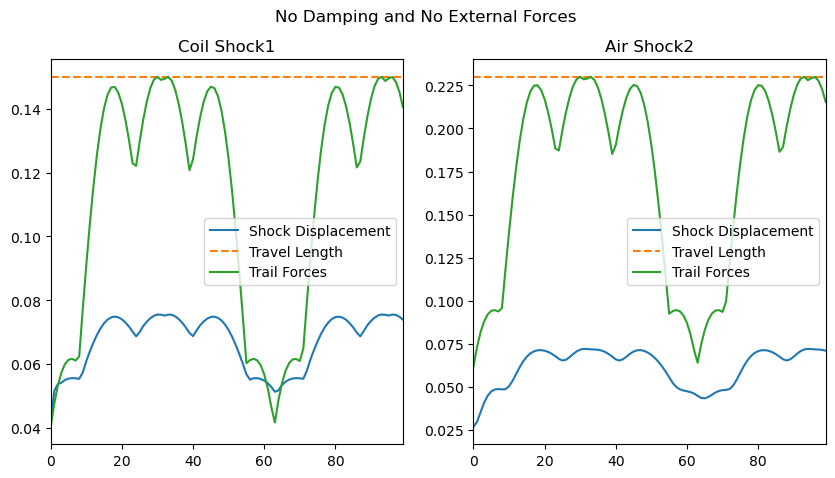

In [ ]:
shock_config1 = {
    "spring_type": "coil",
    "spring_constant": 8230.96, # 5 N/m
    "initial_pressure": 20,
    "rider_weight": 35, # kg
    "progression_tokens": 0,
    "stanchion_diameter": 36, # mm
    "travel_length": 150, # mm
    "temperature": 70,
    "rebound": 100,
    "HSC": 100,
    "LSC": 100,
    "friction": 0.1
}

shock_config2 = {
    "spring_type": "air",
    "spring_constant": 35, # 5 N/m
    "initial_pressure": 100,
    "rider_weight": 100, 
    "progression_tokens": 0,
    "stanchion_diameter": 40,
    "travel_length": 230,
    "temperature": 70,
    "rebound": 100,
    "HSC": 100,
    "LSC": 100,
    "friction": 0.01
}

trail_config = {
    "duration": 100
}

shock = Shock(shock_config1)
shock2 = Shock(shock_config2)
evaluator1 = Evaluator(shock)
evaluator2 = Evaluator(shock2)

trail = Trail(trail_config)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

evaluator1.plot(trail, ax[0], title="Coil Shock1")
evaluator2.plot(trail, ax[1], title="Air Shock2")
fig.suptitle("No Damping and No External Forces")
plt.show()

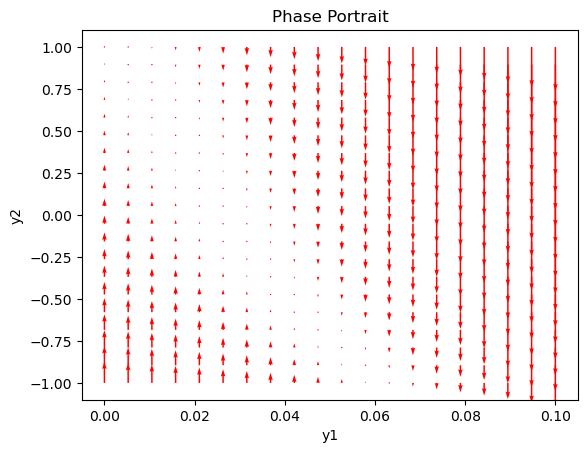

In [62]:
y1 = np.linspace(0, 0.1, 20)
y2 = np.linspace(-1, 1, 20)
Y1, Y2 = np.meshgrid(y1, y2)

# Compute the derivatives at each point on the grid
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape
for i in range(NI):
    for j in range(NJ):
        y = [Y1[i, j], Y2[i, j]]
        dydt = evaluator2.shock.model(0, y, lambda x : 0)
        u[i, j] = dydt[0]
        v[i, j] = dydt[1]

# Plot the phase portrait
plt.quiver(Y1, Y2, u, v, color='r')
plt.xlabel('y1')
plt.ylabel('y2')
plt.title('Phase Portrait')
plt.show()